In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Dependencies**

In [ ]:
!pip install shap

In [ ]:
!pip install tensorflow
import tensorflow

In [ ]:
import os
import shap
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications.resnet50 import ResNet50

# Set seeds to make the experiment more reproducible.
#from tensorflow import set_random_seed
#from tensorflow import set_random_seed
from tensorflow.random import set_seed 
#tf.random.set_seed(seed)
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_seed(seed)

seed = 0
seed_everything(seed)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/COMBINED/glaucoma.csv')
test = pd.read_csv('/content/drive/MyDrive/COMBINED/glaucoma.csv')
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
train["Filename"] = train["Filename"].apply(lambda x: x )
test["Filename"] = test["Filename"].apply(lambda x: x )
train['Glaucoma'] = train['Glaucoma'].astype('str')
display(train.head())

Number of train samples:  650
Number of test samples:  650


,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0


In [ ]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 5
WARMUP_EPOCHS =2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = train['Glaucoma'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
X_train, X_val = train_test_split(train, test_size=0.2, random_state=seed)

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 rotation_range=360,
                                 horizontal_flip=True,
                                 vertical_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory="/content/drive/MyDrive/COMBINED/Train",
    x_col="Filename",
    y_col="Glaucoma",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    seed=0)

validation_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=validation_datagen.flow_from_dataframe(
    dataframe=X_val,
    directory="/content/drive/MyDrive/COMBINED/Validation",
    x_col="Filename",
    y_col="Glaucoma",
    class_mode="categorical", 
    batch_size=BATCH_SIZE,   
    target_size=(HEIGHT, WIDTH),
    seed=0)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "/content/drive/MyDrive/COMBINED/Test",
        x_col="Filename",
        batch_size=1,
        class_mode=None,
        shuffle=False,
        target_size=(HEIGHT, WIDTH),
        seed=0)

Found 416 validated image filenames belonging to 2 classes.
Found 26 validated image filenames belonging to 2 classes.
Found 312 validated image filenames.


In [ ]:
from keras.models import load_model
model =load_model('/content/drive/MyDrive/COMBINED/model_.h5')

In [ ]:
#model = create_model(input_shape=( shape_input), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
    
#class_weights = class_weight.compute_class_weight('balanced', np.unique(train['Glaucoma'].astype('int').values), train['Glaucoma'].astype('int').values)

metric_list = ["accuracy"]
#optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
#model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=metric_list)

model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
import tensorflow as tf

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS
                                     #class_weight=class_weights,
                                     #verbose=0
                                     ).history

Epoch 1/2
52/52 [==============================] - 163s 3s/step - loss: 4.5269 - accuracy: 0.5841 - val_loss: 3.8497 - val_accuracy: 0.8333
Epoch 2/2
52/52 [==============================] - 90s 2s/step - loss: 2.5759 - accuracy: 0.5962 - val_loss: 3.7678 - val_accuracy: 0.7917


In [ ]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=metric_list)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          #class_weight=class_weights,
                                          verbose=1).history

Epoch 1/20
52/52 [==============================] - 291s 5s/step - loss: 13.9652 - accuracy: 0.6562 - val_loss: 12546.0000 - val_accuracy: 0.7917
Epoch 2/20
52/52 [==============================] - 281s 5s/step - loss: 4.9705 - accuracy: 0.6514 - val_loss: 0.6714 - val_accuracy: 0.8750
Epoch 3/20
52/52 [==============================] - 283s 5s/step - loss: 6.8611 - accuracy: 0.7067 - val_loss: 1900.1714 - val_accuracy: 0.7917
Epoch 4/20
52/52 [==============================] - 283s 5s/step - loss: 5.7589 - accuracy: 0.7188 - val_loss: 0.6785 - val_accuracy: 0.8333
Epoch 5/20
52/52 [==============================] - 284s 5s/step - loss: 6.3905 - accuracy: 0.6995 - val_loss: 0.6664 - val_accuracy: 0.8333
Epoch 6/20
52/52 [==============================] - 283s 5s/step - loss: 6.8062 - accuracy: 0.6971 - val_loss: 0.5476 - val_accuracy: 0.7917
Epoch 7/20
52/52 [==============================] - 284s 5s/step - loss: 5.8382 - accuracy: 0.6971 - val_loss: 0.4580 - val_accuracy: 0.8333
Epoch

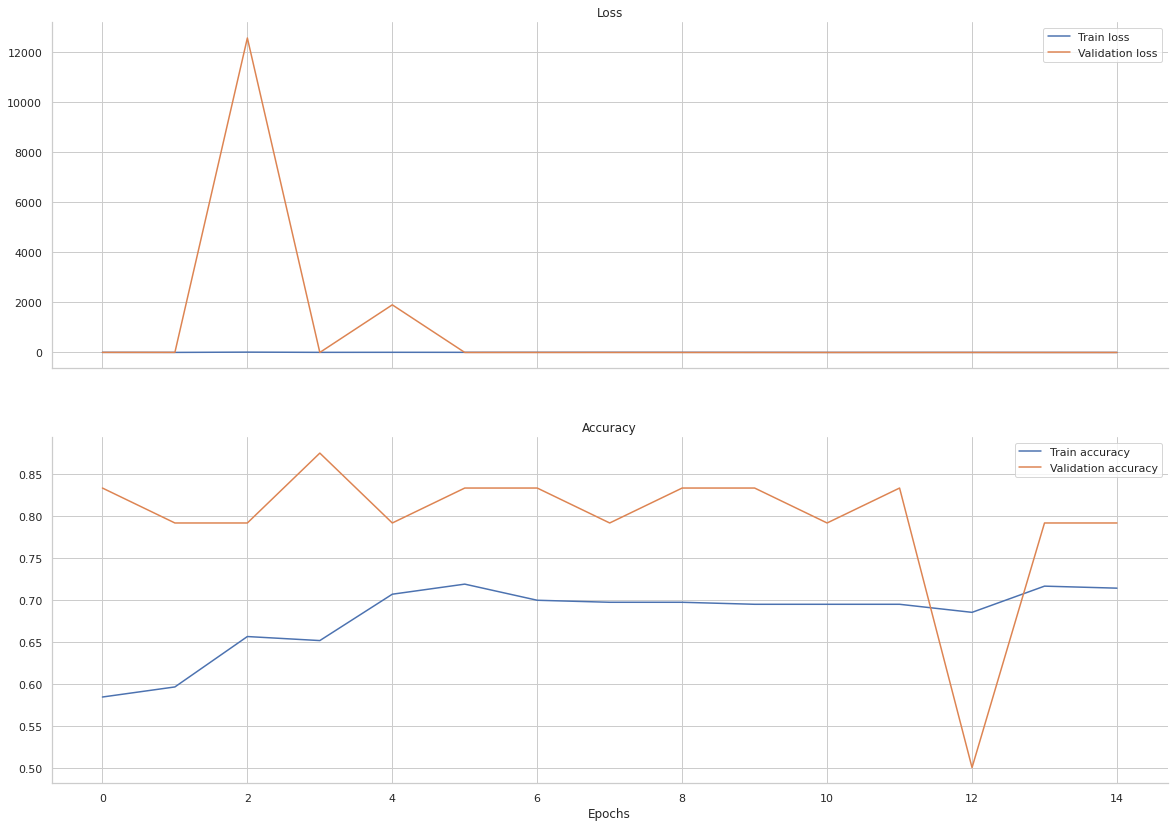

In [ ]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'accuracy': history_warmup['accuracy'] + history_finetunning['accuracy'], 
           'val_accuracy': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['accuracy'], label='Train accuracy')
ax2.plot(history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
# Create empty arays to keep the predictions and labels
lastFullTrainPred = np.empty((0, N_CLASSES))
lastFullTrainLabels = np.empty((0, N_CLASSES))
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

# Add train predictions and labels
for i in range(STEP_SIZE_TRAIN+1):
    im, lbl = next(train_generator)
    scores = model.predict(im, batch_size=train_generator.batch_size)
    lastFullTrainPred = np.append(lastFullTrainPred, scores, axis=0)
    lastFullTrainLabels = np.append(lastFullTrainLabels, lbl, axis=0)

# Add validation predictions and labels
for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(valid_generator)
    scores = model.predict(im, batch_size=valid_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
    
    
lastFullComPred = np.concatenate((lastFullTrainPred, lastFullValPred))
lastFullComLabels = np.concatenate((lastFullTrainLabels, lastFullValLabels))
complete_labels = [np.argmax(label) for label in lastFullComLabels]

train_preds = [np.argmax(pred) for pred in lastFullTrainPred]
train_labels = [np.argmax(label) for label in lastFullTrainLabels]
validation_preds = [np.argmax(pred) for pred in lastFullValPred]
validation_labels = [np.argmax(label) for label in lastFullValLabels]

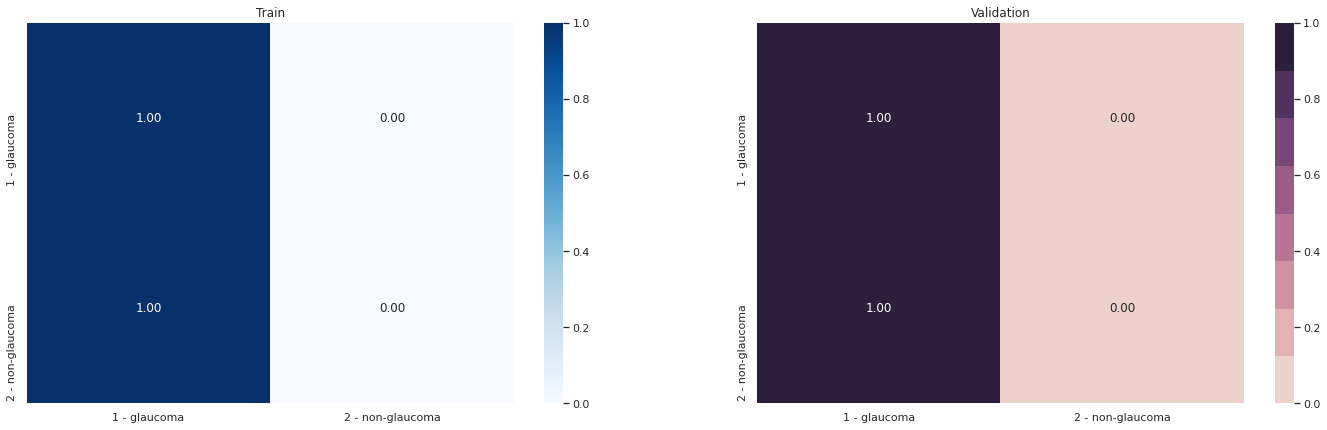

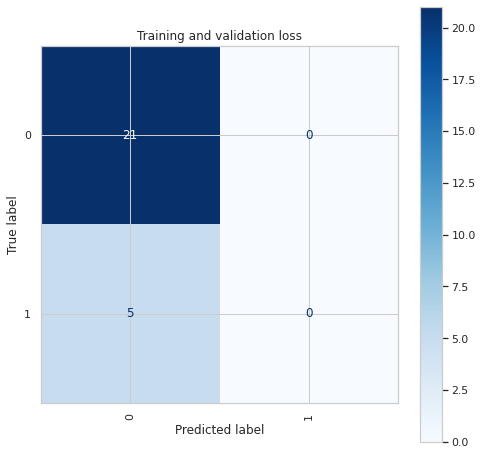

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
#labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
labels=[ '1 - glaucoma', '2 - non-glaucoma']
train_cnf_matrix = confusion_matrix(train_labels, train_preds)
validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax1).set_title('Train')
sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8), ax=ax2).set_title('Validation')
plt.show()


from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
class_names = []
class_names = list(valid_generator .class_indices.keys())
y_true = []
for i in range(0,len(valid_generator )):
  y_true.extend(np.array(valid_generator [i][1]))
y_true = np.argmax(y_true,axis = 1)
y_pred = model.predict(valid_generator ) 
y_pred = np.argmax(y_pred, axis = 1)
cnf_matrix = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,display_labels=class_names)
fig,ax = plt.subplots(figsize=(8,8))
disp = disp.plot(include_values=True,cmap='Blues', xticks_rotation='vertical', values_format='.3g', ax=ax)
plt.title('Training and validation loss')
plt.show()

In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds,train_labels, weights='quadratic'))
print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds+validation_preds, train_labels+validation_labels, weights='quadratic'))

Train Cohen Kappa score: 0.000
Validation Cohen Kappa score: 0.000
Complete set Cohen Kappa score: 0.000


**SHAP MODEL EXPLAINABILITY**

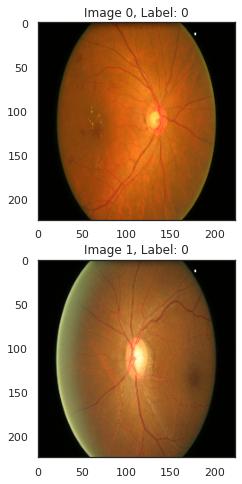

In [ ]:
n_explain = 2
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[8, 8])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

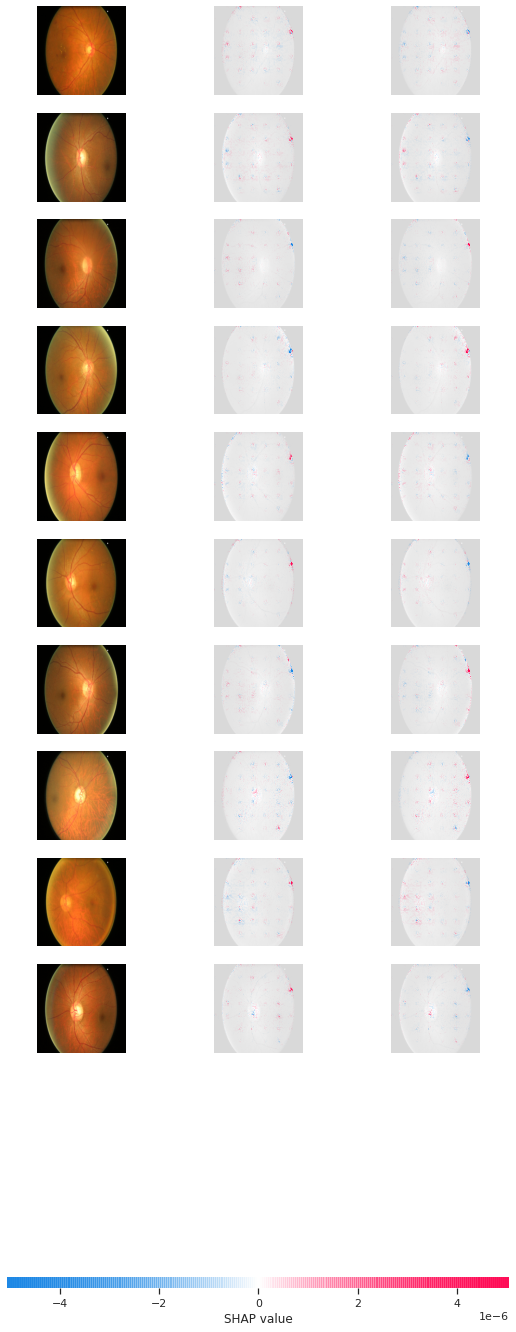

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


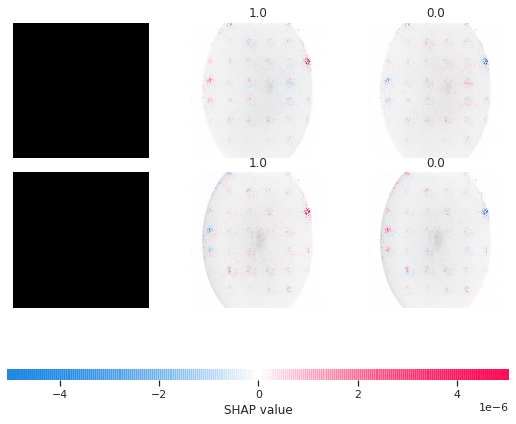

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
#shap_values = e.shap_values(background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, background)
# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

In [ ]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

filenames = test_generator.filenames
results = pd.DataFrame({'Filename':filenames, 'Glaucoma':predictions})
results['Filename'] = results['Filename'].map(lambda x: str(x)[:-4])

In [ ]:
fig = plt.subplots(1, 1, sharex='col', figsize=(24, 8.7))
sns.countplot(x="Glaucoma", data=results, palette="GnBu_d")
sns.despine()
plt.show()

In [ ]:
results.to_csv('submission.csv', index=False)
results.head(10)